In [61]:
import numpy as np
from lib import view, traj_view
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import Image
import json as json 

![title](ML2.png)

# Récuparation de la base de données

Block in which we give a bit of context on the importance of materials prediction starting from their atoms, and how, in order to achieve an accurate number, very expensive calculations are needed.

The definition of a macroscopic property of an assembly of atoms can be made easier by considering a fewer number of atoms instead of $10^{23}\; / cm ^3\; * A_{needed}$  in case one can define repeating units.

Materials which atoms are organized in a perfectly ordered repetition of smaller units are called crystals.
In this notebook you will study the properties of a collection of crystalline materials composed of a wide variety of elements, and see how just by changing their constituents arrangements and their chemistry, one can create materials with very different properties.


In [190]:
#FIRST ACT : Loading the structures 
# Let's for first try to make python read our database. Usually, the form of an atomic 
# structure is given in terms of :
# 1. Atom's cartesian positions in 3D ( their x,y and z coordinates)
# 2. Element of the atom ( H, O, Bi ...)
# 3. Dimension of the unit element that needs to be repeate (cell parameter)

from elements import ELEMENTS
def parser(d):
    mats=[]
    for m in d:
        pos=m['poscar']
        lines=pos.splitlines()
        a=np.array([float(x) for x in lines[2].split()])
        b=np.array([float(x) for x in  lines[3].split()])
        c=np.array([float(x) for x in lines[4].split()])
        #if c[2]< 0: c=-c
        species=lines[5].split()
        spe_count=[int(x) for x in lines[6].split()]
        i=8
        p=[]
        mat={'species':[], 'positions':[],'cell':[a,b,c]}
        for j in range(sum(spe_count)):
            mat['positions'].append(sum([float(x)*np.array(mat['cell'][k]) for k,x in enumerate(lines[i+j].split()[:3])]))
            mat['species'].append(ELEMENTS[lines[i+j].split()[3]].number)
        mats.append(mat)
    return mats
### We will save dd in an ase compatible format to make it easier to read it
#rid = pd.read_json('ec.json')
rid = json.load(open('clean_ec.json'))
#clean_rid=[r for i,r in enumerate(rid) if i not in [1021, 1089]]
#with open('clean_ec.json','w') as f:
#    f.write(json.dumps(clean_rid))
mats = parser(rid)
K=np.array([r["K_VRH"] for r in rid])

In [191]:
##Task number one : Students try to read the xyz file in their possession,here for simplicity parsed in ase
## as a first exercise, they will place the coordinates in position, species in sp and assemble them in a 
## simple dictionary entry called molecule, with two attributes : "pos" and "sp"
print(len(mats))
mol = mats[1021]
view(mol, (1,1,1))

1179


A Jupyter Widget

A Jupyter Widget

# Descripteurs

In [192]:
# As studied in the introductory part, to build a solid prediction scheme we need to be able to come up 
# with "descriptors" which can distiguish them according to their relevant characteristics e.g. packing, 
# recurrent orientation, particular ratio of a species Vs another etc....
# First One : How can we characterize how "packed" they are? Yes, we are talking about density!



#Try calculating the number of atoms per frame in a variable called Nat

def NombreAtomes(mat):
    #Start by the positions vector, and print its length!
    return len(mat['species'])

Nat = np.array([NombreAtomes(mat) for mat in mats])

# How do we calculate the volume of a unit cell? 
# We have its "cell" sides..now, do you remember how to calculate
# the volume of a box ? Vol = a*b*c (Let's hope they're all orthorombic)

def Volume(mat):
    a = mat["cell"][0][0]
    b = mat["cell"][1][1]
    c = mat["cell"][2][2]
    volume = np.abs(a*b*c) ## This will be in Angstrom^3, what if we want it in cm^3?
    return volume

Volumes = np.array([Volume(mat) for mat in mats])

VolumeParAtome=Volumes/Nat

<IPython.core.display.Javascript object>


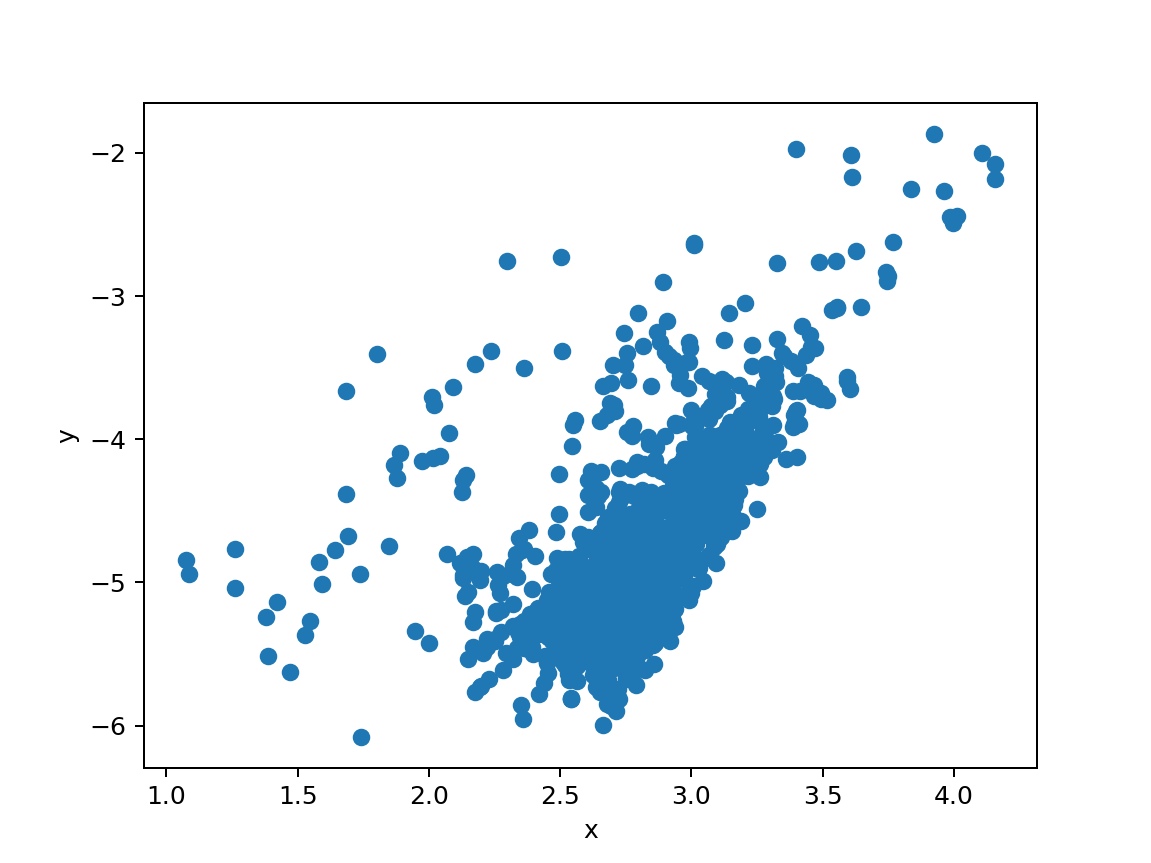

In [194]:
fig=plt.figure()
ax=plt.subplot(111,xlabel='x', ylabel='y')
ax.scatter(np.log(VolumeParAtome), -np.log(K))
plt.show()

We have an additional information encoded in this databse, one that we are not using : the chemical species involved.
The alloys we are trying to describe seem to be composed of different atomic species, ranging from hydrogen to bismuth!! 
Since we have seen that the resistence of a macroscopic alloy is related to the bonding strength of their atomic constitunts, let's classify each of this alloys depending on the species they contain.
We could do as follows: 
Let's prepare a large array of atoms counters (we would make one column per atomic species), one per alloy. In each of the columns we accumulate the number of occurences of its corresponding atomic species, in the selected frame. 
Let's give an example : 

atomic species : $[nH\,\,\,nO]$

frame : $H_2O$

atomic counter : $[2\,\,\,0]$

Now, let's do this for all the frame in this crystal set, and let's see how many atomic species there are!

![title](PT.png)

In [236]:
## CHEMISTRY BLOCK !
# Students are invited to build a dictionary based on the Periodic Table which associates a key to each *group* 
# This will be used later to build a chemical descriptor.
groupes = { 
0 : [1,7,8,9,17,35,53], #Non Metals
1 : [3,11,19,37,55],
2 : [4,12,20,38,56],
3 : [13,30,31,48,49,50,80,81,82,83],
4 : [5,14,32,33,51,52], #Non Metals
5 : [6,15,16,34], #Non Metal
6 : [21,22,23,24,25,26,27,28,29,39,40,41,42,43,44,45,46,47,72,73,74,75,76,77,78,79]}


non_metaux = [1,7,8,9,17,35,53,5,14,32,33,51,52,6,15,16,34]


# Chemical Descriptor : Part I
# The binning of the number of species
## We have a periodic table, we will ask the students to use it to divide the structures between which atom
## is contained in the non metallic and metallic regions. 
## This will give us an idea of which kind of bonding hey will be able to exhibit.

BD_elements = []
for mat in mats:
    for i in mat["species"]:
        if i not in BD_elements:
            BD_elements.append(i)
BD_elements=sorted(BD_elements)
            

###count the occurencies of z species in each frame i 
des_el = np.zeros((len(mats),len(elem_dict1))) 
des_groupe = np.zeros((len(mats),7))
des_met = np.zeros((len(mats),2))

for j,m in enumerate(mats):
    for i in m["species"] :
        des_el[j,BD_elements.index(i)] += 1./Nat[j]
        for key,values in groupes.items() :
            if i in values:
                des_groupe[j,key]+=1./Nat[j]
        if i in non_metaux:
            des_met[j,0]+=1./Nat[j]
        else:
            des_met[j,1]+=1/Nat[j]

descripteur=np.column_stack((VolumeParAtome,des_met))


# Entrainement et test

In [246]:
# TRAIN AND TEST PREPARATION 
# First, create two arrays of indices which will be used to define the train and test sets :
# Wait a minute, how many samples do we have?
X = descripteur
Y=-np.log(K)

ntot = X.shape[0]
print("Nombre de materiaux : ", ntot)


# Choose how many points we want to use to train onto 
fac=0.9
ntrain = int(fac*ntot)
# Keep in mind they have to be less than the total numnber of points : 
# They can't be more, because we can only train on what we know,
# and can't be all of them, as we wouldn't be able to assess how good we would be doing!
indices = np.arange(ntot)
np.random.shuffle(indices)
#If we order them randomly, we can be sure to let everyone have the same probability of being chosen

Nombre de materiaux :  1179


In [247]:
itest = indices[ntrain:]
itrain = indices[:ntrain]

print(len(itest), len(itrain)) 

x_train = X[itrain]
y_train = Y[itrain]

mean = np.mean(y_train)
yc_train = y_train - mean

x_test=X[itest]
y_test=Y[itest]-mean


118 1061


In [248]:
### LOSS FUNCTION  : Our algorithm will produce a predicted property that will be as close as possible 
###                  to the one we have originally
### and
### Prediction Machine : It will be a function of our descriptors, and we will get the weights.


def Prediction(a,X):
    # Linear Model 
    #y_fun = lambda w: 
    if len(a)==1:
        pred = X*a
    else:
        pred = np.dot(X,a)
    return pred


def Cout(a,y_true,X):
    ## It will be a Root Mean square Error
    return np.sqrt(((y_true-Prediction(a,X))**2).mean()) #lossfun 

import itertools

def costNd(a,x, y):
    yn=sum(ai*xi for ai, xi in zip(a,x))
    return np.sum((y-yn)**2)

def best_slopeND(alist,x,y):
    lowestcost=costNd(alist[:,0],x,y)
    best=alist[:,0]
    for ax in itertools.product(*alist):
            c=costNd(ax, x,y)
            if c< lowestcost:
                lowestcost=c
                best=ax
    return best
def DaND(rng, N):
    return [abs(r[1]-r[0])/N for r in rng]
def simple_lregND(x,y,thr, init_rng, N):
    rng=init_rng
    count=0
    while max(DaND(rng,N)) > thr:
        alist=np.array([np.linspace(r[0],r[1],N) for r in rng])
        ba=best_slopeND(alist,x,y)
        count+=N**len(alist)
        rng=[[b-D,b+D] for b,D in zip(ba, DaND(rng,N)) ]
    print("after trying ",count," slopes")
    return ba, count



In [249]:
### Now, finding the weights that allow us to follow our training points requires
### solving an optimization problem, similarly to what you have seen in the introductory part.
### The so called "optimal" weights will be the ones that MINIMIZE a function that measures our
### total error on prediction, called LOSS.

### Since this can be a particularly slow problem to solve, we provide a minimizer that does it for you!
from scipy.optimize import minimize
# Initialize the starting guess for our weights

a0 = np.random.random(X.shape[1])

# Now we minimize!
solution = minimize(lambda a: Cout(a,yc_train,x_train),a0)
a_opt = solution.x
#a_opt, ne = simple_lregND(x_train.T,yc_train,0.000000001, [[-10.0,0],[0.0,2.0],[0.0,2.0]], 7)


#
y_pred=Prediction(a_opt,x_test)
Ypred=np.exp(-(y_pred+mean))

### If you want to look at how complicated our problem was, you
### can print the output of minimize and see how many iterations it took!
#print(solution)

# The coefficients we find
print('Coefficients w*: ', a_opt)
# The mean squared error
print("Erreur: %.2f"
      % Cout(a_opt,y_test, x_test))

Kerr = []
for i in range(len(itest)):
    Kerr.append(int(np.abs( Ypred[i] - K[itest[i]])/K[itest[i]]*100))
print("pourcentage d'erreur moyen sur module d'élasticité: ", np.mean(Kerr),"%")

check=50
print("Predicted : ",Ypred[check])
print("Actual :", K[itest[check]])
#print("Error percentage on test: ", int(np.abs(np.exp(db_y_linear[check]+mean)- rid["K_VRH"][itest[check]])/rid["K_VRH"][itest[check]]*100),"%")


Coefficients w*:  [ 0.07362615 -1.02442422 -1.32367639]
Erreur: 0.42
pourcentage d'erreur moyen sur module d'élasticité:  33.5677966102 %
Predicted :  126.401371582
Actual : 128.601571374


<IPython.core.display.Javascript object>


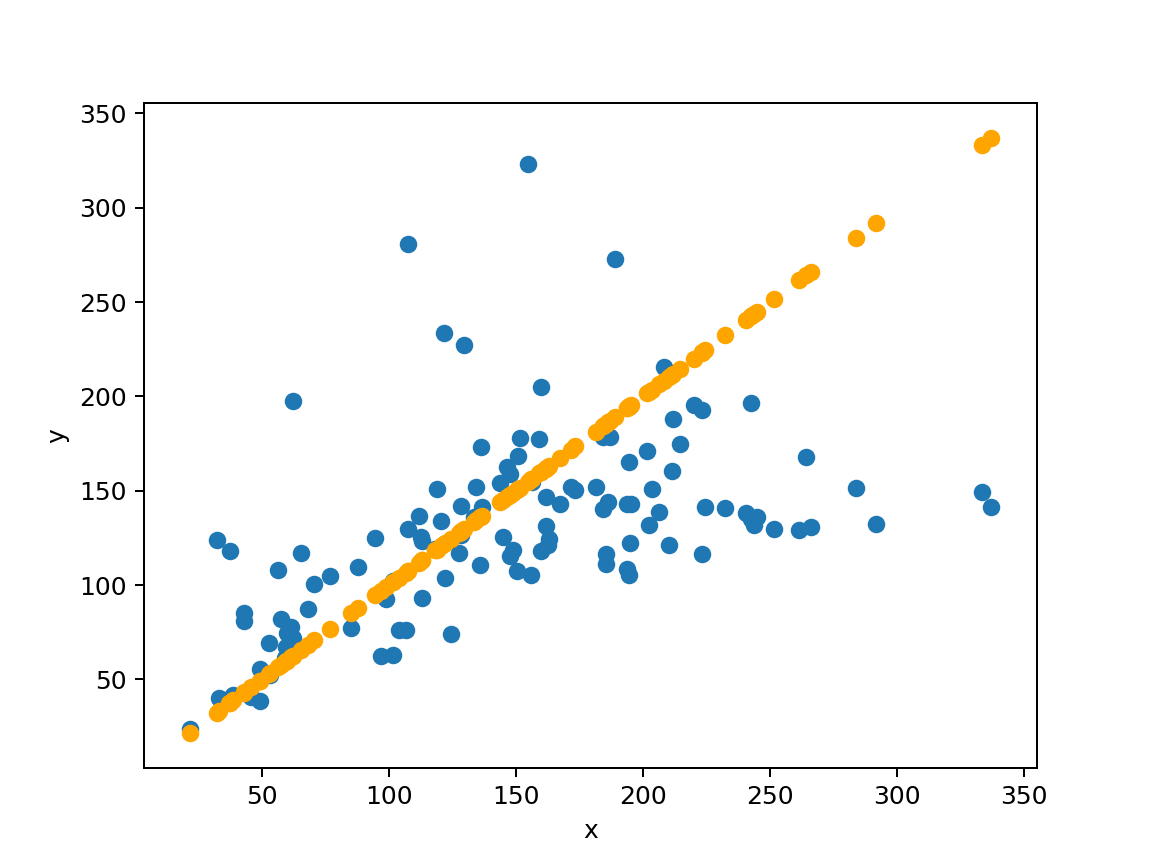

In [250]:
fig=plt.figure()
ax=plt.subplot(111,xlabel='x', ylabel='y')
#ax.scatter(Prediction(a_opt,x_test), y_test)
#ax.scatter(y_test, y_test, c='orange')
ax.scatter(K[itest],Ypred)
ax.scatter(K[itest],K[itest], c='orange')
plt.show()